<div class="alert alert-danger" style="color:black"><b>Running ML-LV Jupyter Notebooks:</b><br>
    <ol>
        <li>Make sure you are running all notebooks using the <code>adv_ai</code> kernel.
        <li><b>It is very important that you do not create any additional files within the weekly folders on CSCT cloud.</b> Any additional files, or editing the notebooks with a different environment may prevent submission/marking of your work.</li>
            <ul>
                <li>NBGrader will automatically fetch and create the correct folders files for you.</li>
                <li>All files that are not the Jupyter notebooks should be stored in the 'ML-LV/data' directory.</li>
            </ul>
        <li>Please <b>do not pip install</b> any python packages (or anything else). You should not need to install anything to complete these notebooks other than the packages provided in the Jupyter CSCT Cloud environment.</li>
    </ol>
    <b>If you would like to run this notebook locally you should:</b><br>
    <ol>
        <li>Create an environment using the requirements.txt file provided. <b>Any additional packages you install will not be accessible when uploaded to the server and may prevent marking.</b></li>
        <li>Download a copy  of the notebook to your own machine. You can then edit the cells as you wish and then go back and copy the code into/edit the ones on the CSCT cloud in-place.</li>
        <li><b>It is very important that you do not re-upload any notebooks that you have edited locally.</b> This is because NBGrader uses cell metadata to track marked tasks. <b>If you change this format it may prevent marking.</b></li>
    </ol>
</div>

# 3 CNN Flower Classification

The CNN performs extremely well on the MNIST data, but this are relatively simple, single channel (greyscale) images. Now lets apply a CNN to a much more difficult task - classifying flowers. The flowers dataset contains 3,670 images of flowers belonging to five different species, Tulips, Roses, Dandilions, Daisys and Sunflowers. Flowers come in many differnt shapes and colours, there are also a variety of backgrounds and even insects within the images, so this is a much more difficult classification problem!

## 3.0 Import libraries

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # Suppress Tensorflow messages
import pickle
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import layers
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay
%matplotlib inline

# Get the status of NBgrader (for skipping cell execution while validating/grading)
grading = True if os.getenv('NBGRADER_EXECUTION') else False

# Set seaborn style for matplotlib plots
plt.style.use('seaborn-v0_8-white')

# Get the project directory (should be in ML-LV)
path = ''
while os.path.basename(os.path.abspath(path)) != 'ML-LV':
    path = os.path.abspath(os.path.join(path, '..'))

# Set the directory to the data folder (should be in ML-LV/data)
data_dir = os.path.join(path, 'data')

# Set the directory to the datasets folder (should be in shared/datasets/flowers)
datasets_dir = os.path.join(path, '..', 'shared', 'datasets', 'flowers')

# Set the directory to the shared models folder (should be in shared/models/flowers)
model_dir = os.path.join(path, '..', 'shared', 'models', 'flowers')

# Set the directory to the VGG weights file (should be in shared/models/vgg)
vgg_weights = os.path.join(path, '..', 'shared', 'models', 'vgg', 'vgg16_imagenet_weights.h5')

## 3.1 Load and pre-process  data

<div class="alert alert-danger" style="color:black"><b>Warning:</b> Loading the full dataset uses ~6GB of memory. To avoid running into issues on CSCT Cloud (e.g. Kernel Crashing) the next cell reduces the proportion of training data that is loaded. This wont impact working on the notebook because you do not need to train any of the models, <b>only use the pre-trained ones provided</b>.<br>

To increase the training set size, in the following cell change <code>["train[:20%]", "train[:20%]"]</code> to <code>["train[:80%]", "train[:20%]"]</code>, which will load 100% of the training data instead of only 20%.
</div>

Number of training images = 734
Number of test images = 734
Shape of the training images = (442, 500, 3)
Shape of the test images = (442, 500, 3)


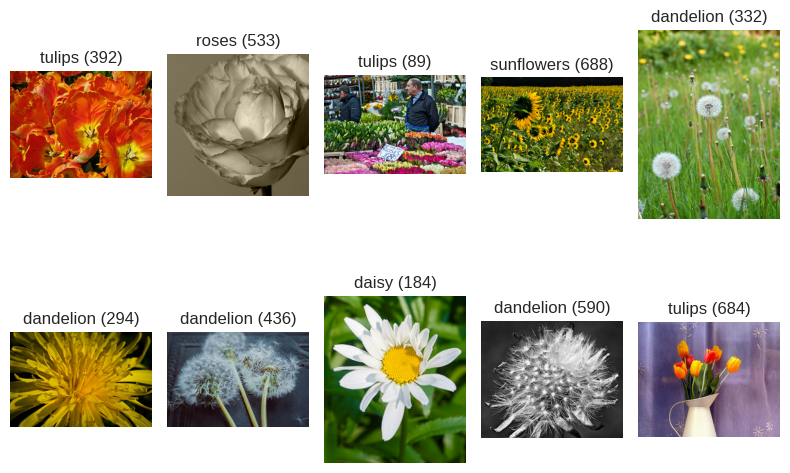

In [2]:
# Load the flowers dataset
((X_train, y_train), (X_test, y_test)), info = tfds.load("tf_flowers",
    data_dir=datasets_dir,
    split=["train[:20%]", "train[:20%]"],
    batch_size=-1,
    as_supervised=True,
    with_info=True
)

# Get the class names
class_names = info.features['label'].names

# Display the number and shape of the images
print(f"Number of training images = {X_train.shape[0]}")
print(f"Number of test images = {X_test.shape[0]}")
print(f"Shape of the training images = {X_train.shape[1:]}")
print(f"Shape of the test images = {X_test.shape[1:]}")

# Function to trim the zeros from an image
def trim_zeros(x):
    slices = tuple(slice(ind.min(), ind.max() + 1) for ind in np.nonzero(x))
    return x[slices]

# Display some random images
rand_index = np.random.choice(range(X_test.shape[0]), 10)
fig, ax = plt.subplots(2, 5, figsize=(8, 6))
ax = ax.ravel()
for i in range(len(rand_index)):
    image = trim_zeros(X_test[rand_index[i]].numpy())
    ax[i].imshow(image)
    name = class_names[y_test[rand_index[i]]] + ' (' + str(rand_index[i]) + ')'
    ax[i].set_title(name)
    ax[i].axis('off')
fig.tight_layout()
plt.show()

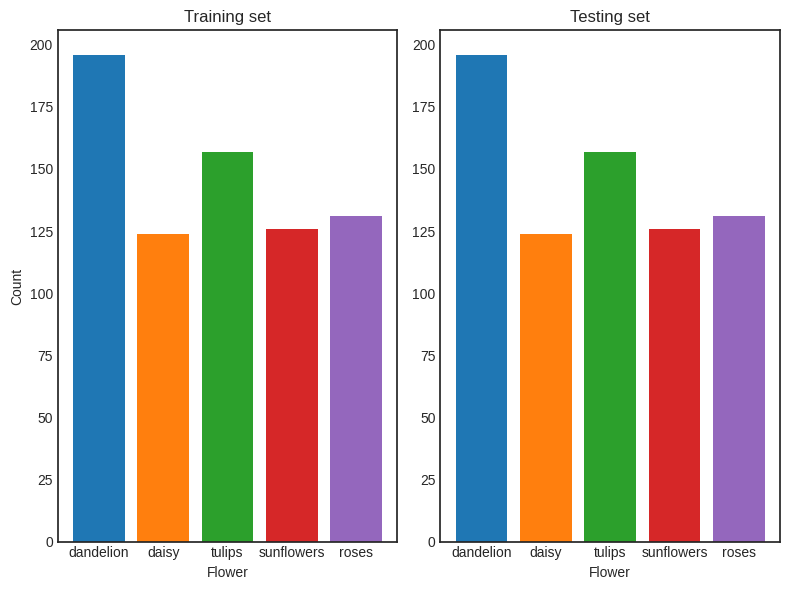

In [4]:
# Display the distribution of the flowers
cmap = plt.get_cmap('tab10')
colours = cmap(range(len(class_names)))
fig, ax = plt.subplots(1, 2, figsize=(8, 6))
ax[0].bar(np.unique(y_train), np.unique(y_train, return_counts=True)[1], color=colours)
ax[0].set_xticks(range(len(class_names)), class_names)
ax[0].set_title('Training set')
ax[0].set_xlabel('Flower')
ax[0].set_ylabel('Count')
ax[1].bar(np.unique(y_test), np.unique(y_test, return_counts=True)[1], color=colours)
ax[1].set_xticks(range(len(class_names)), class_names)
ax[1].set_title('Testing set')
ax[1].set_xlabel('Flower')
plt.tight_layout()
plt.show()

<div class="alert alert-info" style="color:black"><h2>3.2 Exercise: CNN architectures</h2>

Now we can create a CNN model similar to the one we used for the MNIST data. However, we will include a few key differences:
- To avoid overfitting we can include `dropout` layers after each Convolution and Pooling pair.
- To reduce parameters and improve performance we will use a [GlobalAveragePooling](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GlobalAveragePooling2D) layer, instead of simply Flattening the output of the Convolution layers.

1. In the following cell complete the `build_model()` function. It should take in the following arguments and return a Keras functional model:
    - `image_dim` is the *target* size for the input images e.g. this is what they should be resized to.
    - `layers_list` is a list of tuples containing the number of filters and kernel size for each convolutional layer. Thus the length of the list is also the number of convolutional and pooling layers. For example: `[(16, 3), (32, 3)]` is two convolutional layers with 16 and 32 filters respectively and kernel size of 3.
    - `pool_size` is the size of the pooling operations.
    - `dropout` is the dropout rate for each intermediate dropout layer after a pooling layer.
    - `units` is the number of neurons in the penultimate classification layer.
    - `n_class` is the number of classes to predict, or the shape of the output layer.
    - `optimiser` is the optimiser to use.
    - `lr` is the learning rate for the optimiser.

2. You will need to include the [Rescaling](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Rescaling) layer and ensure images are rescaled to the range [0, 1].

3. You should [Resize](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Resizing) the images to the target dimension defined by `image_dim`.

4. After the convolution layers you should apply [GlobalAveragePooling](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GlobalAveragePooling2D).

5. The classification layers should consist of two dense layers with dropout in between. The first dense layer has `units` number of neurons and the second `n_class` neurons

6. Once all the layers are implemented the function should compile the model with the given optimiser and return it.

<br>
<b>This exercise is <u>not</u> marked.</b>
</div>

In [78]:
def build_model(image_dim, layers_list, pool_size, dropout, units, n_class, optimiser='adam', lr=0.001):
    """Builds a CNN model with the given parameters.
    
    Arguments:
        image_dim (tuple): The target dimensions of the input images
        layers_list (list): The list of tuples containing the number of filters and kernel size for each convolutional layer
        pool_size (int): The size of the max pooling layers
        dropout (int): The dropout rate
        units (int): The number of units in the penultimate classification layer
        n_class (int): The number of classes to predict
        optimiser (str): The optimiser to use
        lr (str): The optimiser learning rate to use
    """
    # YOUR CODE HERE
    #raise NotImplementedError()
    
    from tensorflow.keras.models import Model
    from tensorflow.keras.layers import Input, Rescaling, Resizing, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout
    from tensorflow.keras.optimizers import Adam
    

    # Define the model
    inputs = Input(shape=(None, None, 3), name='input_layer')
    x = Rescaling(1./255)(inputs)
    x = Resizing(image_dim[0], image_dim[1])(x)

    # Adding convolutional and pooling layers
    x = Conv2D(16, (3, 3), activation='relu', name='conv_1')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(dropout)(x)
    x = Conv2D(32, (3, 3), activation='relu', name='conv_2')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(dropout)(x)

    # Adding global average pooling layer
    x = GlobalAveragePooling2D()(x)

    # Adding hidden layers and dropout layers
    x = Dense(units=units, activation='relu',name='dense_1')(x)
    x = Dropout(rate=dropout)(x)

    # Adding output layer
    outputs = Dense(units=n_class, activation='softmax', )(x)

    # Define the model
    model = Model(inputs=inputs, outputs=outputs)

    # Compiling the model with optimiser, loss, and accuracy metric
    if optimiser == 'adam':
        optimiser = Adam(learning_rate=lr)
    model.compile(
        optimizer=optimiser,
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model

# # Test
# layer_list = [(16, 3), (32, 3)]
# model = build_model(
#     image_dim=(128, 128),
#     layers_list=layer_list,
#     pool_size=2,
#     dropout=0.2,
#     units=32,
#     n_class=1,
#     optimiser='adam',
#     lr=0.001
# )

# # Test the model is a functional model
# print("Model type:", type(model))

# # Test the number of layers
# print("Number of layers:", len(model.layers))

# # Test the size of the input shape
# print("Input shape:", model.input_shape)

# # Test the first two layers are the rescale and resize layers
# print("Second layer type:", type(model.layers[1]))
# print("Third layer type:", type(model.layers[2]))

# # Test the output shape of the resize layer
# print("Output shape of Resize layer:", model.layers[2].output.shape)

In [79]:
# Test cell (0 marks)

# Create a model using the build_model function
layer_list = [(16, 3), (32, 3)]
model = build_model(
    image_dim=(128, 128),
    layers_list=layer_list,
    pool_size=2,
    dropout=0.2,
    units=32,
    n_class=1,
    optimiser='adam',
    lr=0.001
)

# Test the model is a functional model
assert str(type(model)) == "<class 'keras.src.models.functional.Functional'>", 'Model should be a Functional Model'

# Test the number of layers
assert len(model.layers) == 13, 'Model should have 13 layers'

# Test the size of the input shape
assert model.input_shape == (None, None, None, 3), 'Input shape should be (None, None, None, 3)'

# Test the first two layers are the rescale and resize layers
assert isinstance(model.layers[1], layers.Rescaling), 'Second layer should be the rescale layer'
assert isinstance(model.layers[2], layers.Resizing), 'Third layer should be the resize layer'

# Test the output shape of the resize layer
assert model.layers[2].output.shape == (None, 128, 128, 3), 'Resize layer should have an output shape of (None, 128, 128, 3)'

# Test the convolution blocks
for i in range(len(layer_list)):
    j = 3 * i
    assert isinstance(model.layers[j+3], layers.Conv2D), f'Layer {j+3} should be a convolutional layer'
    assert model.layers[j+3].filters == layer_list[i][0], f'Layer {j+3} should have {layer_list[i][0]} filters'
    assert model.layers[j+3].kernel_size == (layer_list[i][1], layer_list[i][1]), f'Layer {j+3} should have a kernel size of ({layer_list[i][1]}, {layer_list[i][1]})'

    assert isinstance(model.layers[j+4], layers.MaxPooling2D), f'Layer {j+4} should be a max pooling layer'
    assert model.layers[j+4].pool_size == (2, 2), f'Layer {j+4} should have a pool size of (2, 2)'

    assert isinstance(model.layers[j+5], layers.Dropout), f'Layer {j+5} should be a dropout layer'
    assert model.layers[j+5].rate == 0.2, f'Layer {j+5} should have a dropout rate of 0.2'

# Test the global average pooling layer
assert isinstance(model.layers[-4], layers.GlobalAveragePooling2D), 'Layer 9 should be a global average pooling layer'

# Test the classification layers
assert isinstance(model.layers[-3], layers.Dense), 'Layer 10 should be a dense layer'
assert model.layers[-3].units == 32, 'Layer 10 should have 32 units'
assert isinstance(model.layers[-2], layers.Dropout), 'Layer 11 should be a dropout layer'
assert isinstance(model.layers[-1], layers.Dense), 'Layer 12 should be a dense layer'
assert model.layers[-1].units == 1, 'Layer 12 should have 1 units'

# Test the optimiser
assert isinstance(model.optimizer, tf.keras.optimizers.Adam), 'Model should use the Adam optimiser'

# Test the learning rate
assert model.optimizer.learning_rate == 0.001, 'Model should have a learning rate of 0.001'

print('All tests passed!')

All tests passed!


In [ ]:
# Hidden test cell (0 marks)
# Tests all function parameters with different values


### Build the CNN

In [80]:
layer_list = [(32, 5), (64, 3), (96, 3), (96, 3)]
model = build_model(
    image_dim=(256, 256),
    layers_list=layer_list,
    pool_size=2,
    dropout=0.2,
    units=128,
    n_class=5,
    optimiser='adam',
    lr=0.001
)

model.summary()

Model: "functional_29"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, None, None, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_28 (Rescaling)        │ (None, None, None, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resizing_23 (Resizing)          │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_62 (Conv2D)              │ (None, 254, 254, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_60 (MaxPooling2D) │ (None, 127, 127, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_87 (Dropout)            │ (None, 127, 127, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_63 (Conv2D)              │ (None, 125, 125, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_61 (MaxPooling2D) │ (None, 62, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_88 (Dropout)            │ (None, 62, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_29     │ (None, 32)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_55 (Dense)                │ (None, 128)            │         4,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_89 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_56 (Dense)                │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,957 (38.89 KB)

 Trainable params: 9,957 (38.89 KB)

 Non-trainable params: 0 (0.00 B)

### Train and evaluate the model

<div class="alert alert-danger" style="color:black"><b>Warning:</b> Please do not run this cell on UWE machines/CSCT cloud!<br>
This training process can take a <em>very</em> long time! It could take many hours, depending on your hardware, and especially if you do not have a GPU. Instead, <b>skip this cell and load one the pre-trained model provided</b> (below).
</div>

In [ ]:
# if not grading:
#     model_chkptr = tf.keras.callbacks.ModelCheckpoint(
#         os.path.join(data_dir, 'flowers_cnn.weights.h5'),
#         monitor='loss',
#         verbose=0,
#         save_best_only=True,
#         save_weights_only=True,
#         mode='min',
#         save_freq='epoch')
    
#     model_earlystp = tf.keras.callbacks.EarlyStopping(
#         monitor="val_loss",
#         min_delta=0.001,
#         patience=5,
#         verbose=0,
#         mode="min",
#         restore_best_weights=True)

#     # Fit the model
#     results = model.fit(X_train, y_train, epochs=100, validation_split=0.2, batch_size=64, callbacks=[model_chkptr, model_earlystp], verbose=2)
#     # Save the results
#     with open(os.path.join(data_dir, 'flowers_cnn_results.pkl'), 'wb') as file:
#         pickle.dump(results.history, file)

Train loss: 0.749
Train accuracy: 0.711
Best validation loss: 0.825
Best validation accuracy: 0.687


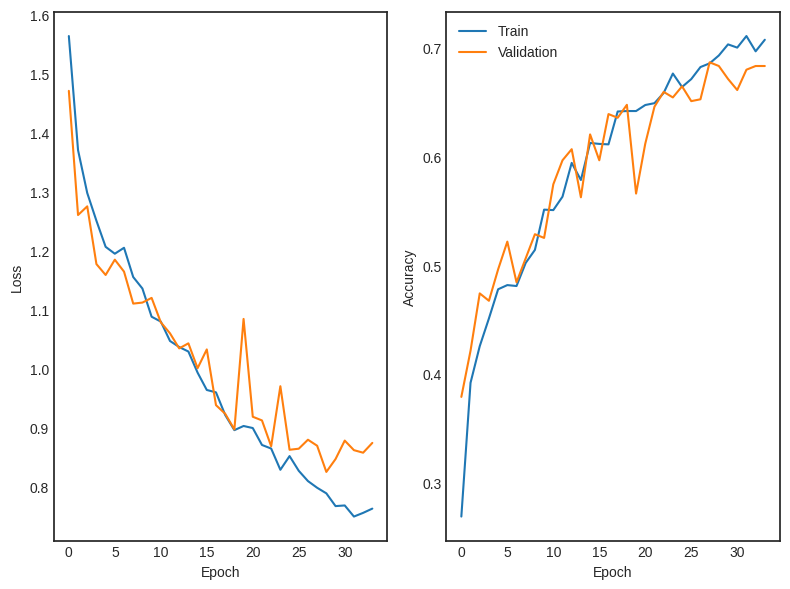

In [81]:
try: results
except NameError: results = None
if grading or not results:
    # Load the results
    with open(os.path.join(model_dir, 'flowers_cnn_results.pkl'), 'rb') as file:
        metrics = pickle.load(file)
elif not grading and results:  
    # Or get them from model training
    metrics = results.history

# Show best loss and accuracy
print(f"Train loss: {min(metrics['loss']):.3f}")
print(f"Train accuracy: {max(metrics['accuracy']):.3f}")
print(f"Best validation loss: {min(metrics['val_loss']):.3f}")
print(f"Best validation accuracy: {max(metrics['val_accuracy']):.3f}")

# Plot the training loss and accuracy
fig, ax = plt.subplots(1, 2, figsize=(8, 6), sharex=True, sharey=False)
ax[0].plot(metrics['loss'], label='Train Loss')
ax[0].plot(metrics['val_loss'], label='Validation Loss')
ax[0].set(xlabel='Epoch', ylabel='Loss')
ax[1].plot(metrics['accuracy'], label='Train Accuracy')
ax[1].plot(metrics['val_accuracy'], label='Validation Accuracy')
ax[1].set(xlabel='Epoch', ylabel='Accuracy')
plt.legend(['Train', 'Validation'])
plt.tight_layout()
plt.show()

/opt/conda/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 26 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


23/23 ━━━━━━━━━━━━━━━━━━━━ 9s 376ms/step
Test Accuracy: 0.668


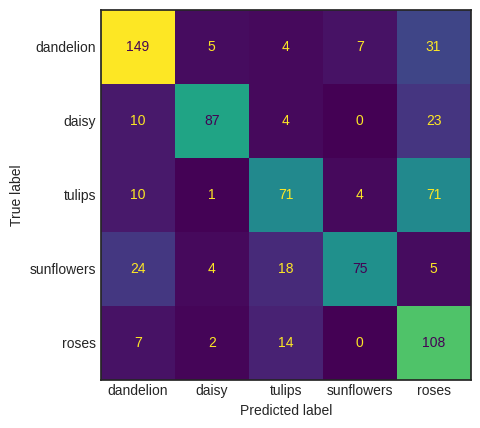

In [65]:
if not grading:
    # Load the best model
    model.load_weights(os.path.join(model_dir, 'flowers_cnn.weights.h5'))

    # Predict class labels for test set
    predictions = model.predict(X_test)
    predictions = np.argmax(predictions, axis=1)
    print(f'Test Accuracy: {accuracy_score(y_test, predictions):.3f}')

    # Print confusion matrix
    conf_matrix = ConfusionMatrixDisplay.from_predictions(y_test, predictions, display_labels=class_names, colorbar=False)
    plt.show()

<div class="alert alert-info" style="color:black"><h2>3.3 Exercise: Data augmentation</h2>

The previous model tends to overfit quite quickly. This is indicated by the validation loss diverging from the training loss after ~20 epochs, as does the accuracy. To reduce overfitting we can add some data augmentation layers, which randomly add transformations (rotate, translate, flip, zoom, add contrast/brightness etc) to the data during training. This increases diversity within the training examples and can also be used to artificially increase the size of the dataset.

Now we can create a CNN model similar to the one we used previously in 3.2. However, we will include a few augmentation layers after the pre-processing layers. You can copy/paste your code from the previous exercise and simply add in the augmentation layers required. 

1. In the following cell complete the `build_augmentation_model()` function. It should take in the following arguments and return a Keras functional model:
    - `image_dim` is the *target* size for the input images e.g. this is what they should be resized to.
    - `flip` is the [RandomFlip](https://www.tensorflow.org/api_docs/python/tf/keras/layers/RandomFlip) layer's `mode` argument.
    - `rotation` is the [RandomRotation](https://www.tensorflow.org/api_docs/python/tf/keras/layers/RandomRotation) layer's `factor` argument.
    - `layers_list` is a list of tuples containing the number of filters and kernel size for each convolutional layer. Thus the length of the list is also the number of convolutional and pooling layers. For example: `[(16, 3), (32, 3)]` is two convolutional layers with 16 and 32 filters respectively and kernel size of 3.
    - `pool_size` is the size of the pooling operations.
    - `dropout` is the dropout rate for each intermediate dropout layer after a pooling layer.
    - `units` is the number of neurons in the penultimate classification layer.
    - `n_class` is the number of classes to predict, or the shape of the output layer.
    - `optimiser` is the optimiser to use.
    - `lr` is the learning rate for the optimiser.

2. The augmentation layers should be applied *after* the pre-processing layers.

3. This model takes longer to train but achieves (slightly) higher accuracy and with reduced overfitting. With a little experimentation this could be increased further.

<b>MARKS AVAILABLE: 5</b>
<br>
<b>MO1</b>
</div>

In [87]:
def build_augmentation_model(image_dim, flip, rotation, layers_list, pool_size, dropout, units, n_class, optimiser='adam', lr=0.001):
    """Builds a CNN model with the given parameters.
    
    Arguments:
        image_dim (tuple): The target dimensions of the input images
        flip (str): The type of flip to apply
        rotation (float): The maximum rotation to apply (in radians)
        layers_list (list): The list of tuples containing the number of filters and kernel size for each convolutional layer
        pool_size (int): The size of the max pooling layers
        dropout (int): The dropout rate
        units (int): The number of units in the penultimate classification layer
        n_class (int): The number of classes to predict
        optimiser (str): The optimiser to use
        lr (str): The optimiser learning rate to use
    """
    # YOUR CODE HERE
    #raise NotImplementedError()
    
    from tensorflow.keras.models import Model
    from tensorflow.keras.layers import Input, Rescaling, Resizing, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout, RandomFlip, RandomRotation, RandomTranslation, RandomZoom
    from tensorflow.keras.optimizers import Adam

    
    # adapted from above exercises 9-2 and 7-2
    
    # Input layer takes an image of size image_dim
    inputs = Input(shape=(None, None, 3), name='input_layer')

    # Pass the image through the pre-processing pipeline
    x = Rescaling(1./255, name='rescale')(inputs)
    x = Resizing(image_dim[0], image_dim[1], name='resize')(x)

    # Adding data augmentation layers
    x = RandomFlip(mode=flip, name='random_flip')(x)
    x = RandomRotation(factor=(-rotation, rotation), name='random_rotation')(x)

    # First convolutional layer with 8 filters of size 5x5, followed by max pooling
    x = Conv2D(filters=8, kernel_size=(5, 5), padding='same', activation='relu', name='conv_1')(x)
    x = MaxPooling2D(pool_size=(pool_size, pool_size), padding='same', name='pool_1')(x)
    x = Dropout(dropout, name='dropout_1')(x)

    # Second convolutional layer with 8 filters of size 3x3, followed by max pooling
    x = Conv2D(filters=8, kernel_size=(3, 3),  padding='same', activation='relu', name='conv_2')(x)
    x = MaxPooling2D(pool_size=(pool_size, pool_size), padding='same', name='pool_2')(x)
    x = Dropout(dropout, name='dropout_2')(x)

    # Global average pooling layer
    x = GlobalAveragePooling2D(name='global_average_pooling')(x)

    # Classification layers with 32, and 5 neurons respectively
    x = Dense(32, activation='relu', name='dense_1')(x)
    x = Dropout(dropout, name='dropout_3')(x)
    outputs = Dense(5, activation='softmax', name='output')(x)

    # Define the model
    model = Model(inputs=inputs, outputs=outputs)

    # Compiling the model with optimiser, loss, and accuracy metric
    if optimiser == 'adam':
        optimiser = Adam(learning_rate=lr)
    model.compile(
        optimizer=optimiser,
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model


# layer_list = [(16, 3), (32, 3)]
# model = build_augmentation_model(
#     image_dim=(128, 128),
#     flip='horizontal',
#     rotation=0.1,
#     layers_list=layer_list,
#     pool_size=2,
#     dropout=0.2,
#     units=32,
#     n_class=1,
#     optimiser='adam',
#     lr=0.001
# )

# # Test the number of layers
# print("Number of layers:", len(model.layers))

# # Test the size of the input shape
# print("Input shape:", model.input_shape)

# # Test the first two layers are the rescale and resize layers
# print("Second layer type:", type(model.layers[1]))
# print("Third layer type:", type(model.layers[2]))

# # Test the output shape of the resize layer
# print("Output shape of Resize layer:", model.layers[2].output.shape)

In [88]:
# Test cell (3 marks)

# Create a model using the build_augmentation_model function
layer_list = [(16, 3), (32, 3)]
model = build_augmentation_model(
    image_dim=(128, 128),
    flip='horizontal',
    rotation=0.1,
    layers_list=layer_list,
    pool_size=2,
    dropout=0.2,
    units=32,
    n_class=1,
    optimiser='adam',
    lr=0.001
)

# Test the model is a functional model
assert str(type(model)) == "<class 'keras.src.models.functional.Functional'>", 'Model should be a Functional Model'

# Test the number of layers
assert len(model.layers) == 15, 'Model should have 15 layers'

# Test the size of the input shape
assert model.input_shape == (None, None, None, 3), 'Input shape should be (None, None, None, 3)'

# Test the first two layers are the rescale and resize layers
assert isinstance(model.layers[1], layers.Rescaling), 'Second layer should be the rescale layer'
assert isinstance(model.layers[2], layers.Resizing), 'Third layer should be the resize layer'

# Test the output shape of the resize layer
assert model.layers[2].output.shape == (None, 128, 128, 3), 'Resize layer should have an output shape of (None, 128, 128, 3)'

# Test the data augmentation layers
assert isinstance(model.layers[3], layers.RandomFlip), 'Layer 4 should be a random flip layer'
assert model.layers[3].mode == 'horizontal', 'Layer 4 should have a mode of horizontal'

assert isinstance(model.layers[4], layers.RandomRotation), 'Layer 5 should be a random rotation layer'
assert model.layers[4].get_config()['factor'] == [-0.1, 0.1], 'Layer 5 should have a factor of [-0.1, 0.1]'

print('All tests passed!')

All tests passed!


In [ ]:
# Hidden test cell (2 marks)
# Tests all function parameters with different values


### Build the Augmentation CNN

In [61]:
layer_list = [(32, 5), (64, 3), (96, 3), (96, 3)]
model = build_augmentation_model(
    image_dim=(256, 256),
    flip='horizontal',
    rotation=0.1,
    layers_list=layer_list,
    pool_size=2,
    dropout=0.2,
    units=128,
    n_class=5,
    optimiser='adam',
    lr=0.001
)

model.summary()

Model: "functional_22"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, None, None, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_24 (Rescaling)        │ (None, None, None, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resizing_17 (Resizing)          │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_flip_5 (RandomFlip)      │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation_5               │ (None, 256, 256, 3)    │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_50 (Conv2D)              │ (None, 252, 252, 32)   │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_50 (MaxPooling2D) │ (None, 126, 126, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_73 (Dropout)            │ (None, 126, 126, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_51 (Conv2D)              │ (None, 124, 124, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_51 (MaxPooling2D) │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_74 (Dropout)            │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_52 (Conv2D)              │ (None, 60, 60, 96)     │        55,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_52 (MaxPooling2D) │ (None, 30, 30, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_75 (Dropout)            │ (None, 30, 30, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_53 (Conv2D)              │ (None, 28, 28, 96)     │        83,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_53 (MaxPooling2D) │ (None, 14, 14, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_76 (Dropout)            │ (None, 14, 14, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_23     │ (None, 96)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_46 (Dense)                │ (None, 128)            │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_77 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_47 (Dense)                │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 172,421 (673.52 KB)

 Trainable params: 172,421 (673.52 KB)

 Non-trainable params: 0 (0.00 B)

### Train and evaluate the model

<div class="alert alert-danger" style="color:black"><b>Warning:</b> Please do not run this cell on UWE machines/CSCT cloud!<br>
This training process can take a <em>very</em> long time! It could take many hours, depending on your hardware, and especially if you do not have a GPU. Instead, <b>skip this cell and load one the pre-trained model provided</b> (below).
</div>

In [ ]:
# if not grading:
#     model_chkptr = tf.keras.callbacks.ModelCheckpoint(
#         os.path.join(data_dir, 'flowers_augmented_cnn.weights.h5'),
#         monitor='loss',
#         verbose=0,
#         save_best_only=True,
#         save_weights_only=True,
#         mode='min',
#         save_freq='epoch')
    
#     model_earlystp = tf.keras.callbacks.EarlyStopping(
#         monitor="val_loss",
#         min_delta=0.001,
#         patience=10,
#         verbose=0,
#         mode="min",
#         restore_best_weights=True)

#     # Fit the model
#     results = model.fit(X_train, y_train, epochs=100, validation_split=0.2, batch_size=64, callbacks=[model_chkptr, model_earlystp], verbose=2)
#     # Save the results
#     with open(os.path.join(data_dir, 'flowers_augmented_cnn_results.pkl'), 'wb') as file:
#         pickle.dump(results.history, file)

Train loss: 0.607
Train accuracy: 0.767
Best validation loss: 0.718
Best validation accuracy: 0.755


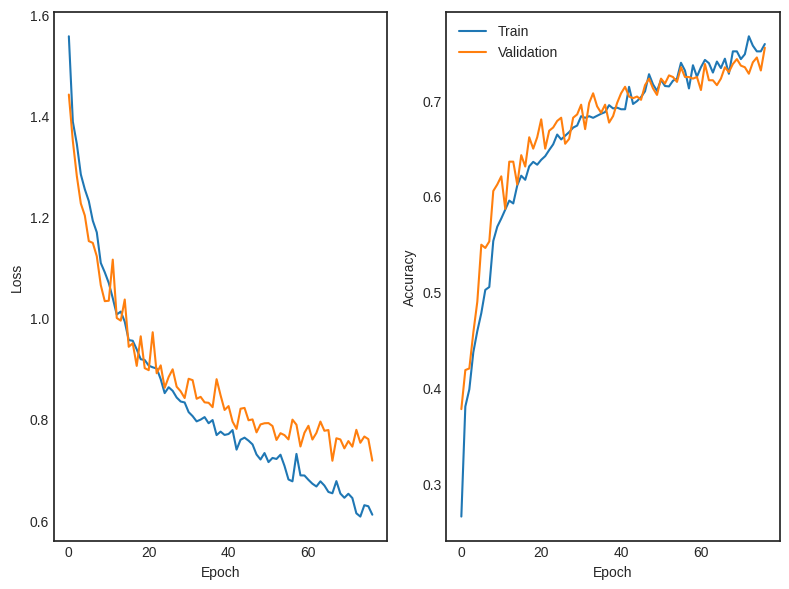

In [62]:
try: results
except NameError: results = None
if grading or not results:
    # Load the results
    with open(os.path.join(model_dir, 'flowers_augmented_cnn_results.pkl'), 'rb') as file:
        metrics = pickle.load(file)
elif not grading and results:  
    # Or get them from model training
    metrics = results.history

# Show best loss and accuracy
print(f"Train loss: {min(metrics['loss']):.3f}")
print(f"Train accuracy: {max(metrics['accuracy']):.3f}")
print(f"Best validation loss: {min(metrics['val_loss']):.3f}")
print(f"Best validation accuracy: {max(metrics['val_accuracy']):.3f}")

# Plot the training loss and accuracy
fig, ax = plt.subplots(1, 2, figsize=(8, 6), sharex=True, sharey=False)
ax[0].plot(metrics['loss'], label='Train Loss')
ax[0].plot(metrics['val_loss'], label='Validation Loss')
ax[0].set(xlabel='Epoch', ylabel='Loss')
ax[1].plot(metrics['accuracy'], label='Train Accuracy')
ax[1].plot(metrics['val_accuracy'], label='Validation Accuracy')
ax[1].set(xlabel='Epoch', ylabel='Accuracy')
plt.legend(['Train', 'Validation'])
plt.tight_layout()
plt.show()

23/23 ━━━━━━━━━━━━━━━━━━━━ 9s 384ms/step
Test Accuracy: 0.782


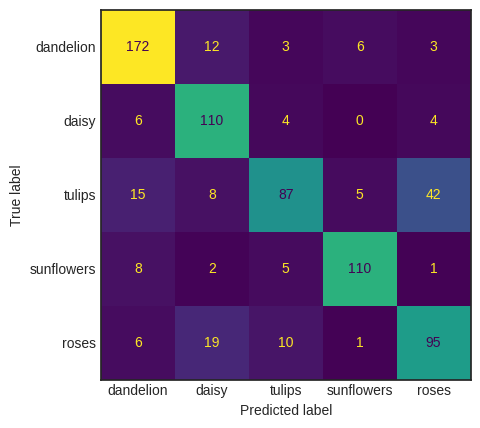

In [63]:
if not grading:
    # Load the best model
    model.load_weights(os.path.join(model_dir, 'flowers_augmented_cnn.weights.h5'))

    # Predict class labels for test set
    predictions = model.predict(X_test)
    predictions = np.argmax(predictions, axis=1)
    print(f'Test Accuracy: {accuracy_score(y_test, predictions):.3f}')

    # Print confusion matrix
    conf_matrix = ConfusionMatrixDisplay.from_predictions(y_test, predictions, display_labels=class_names, colorbar=False)
    plt.show()

<div class="alert alert-info" style="color:black"><h2>3.4 Exercise: Transfer learning</h2>

Just as with NLP, transfer learning is a highly effective method of building powerful models using the weights of large pre-trained image classifiers. Keras has many pre-trained models 'built in' to the [`tf.keras.applications`](https://www.tensorflow.org/api_docs/python/tf/keras/applications) module. To use these models we can replace *all* of the convolution and pooling layers with a single pre-trained model that acts like a feature extractor, leaving only the classifier layers needing to be trained for the specific task.

Now we can create a CNN model that uses a pre-trained deep CNN model for feature extraction. You can copy/paste your code from the previous exercise and simply replace most of the CNN layers with [VGG16](https://www.tensorflow.org/api_docs/python/tf/keras/applications/vgg16). 

1. In the following cell complete the `build_vgg_model()` function. It should take in the following arguments and return a Keras functional model:
    - `image_dim` is the *target* size for the input images, e.g. this is what they should be resized to.
    - `flip` is the [RandomFlip](https://www.tensorflow.org/api_docs/python/tf/keras/layers/RandomFlip) layer's `mode` argument.
    - `rotation` is the [RandomRotation](https://www.tensorflow.org/api_docs/python/tf/keras/layers/RandomRotation) layer's `factor` argument.
    - `weights` is the *path* to the pre-trained VGG weights, e.g. `vgg_weights`.
    - `filters` is the number of filters for a *single* convolutional layer after the VGG feature extractor.
    - `kernel` is the kernel size for a *single* convolutional layer after the VGG feature extractor.
    - `n_class` is the number of classes to predict, or the shape of the output layer.
    - `optimiser` is the optimiser to use.
    - `lr` is the learning rate for the optimiser.

2. You need to resize the images and then use the VGG `preprocess_input()` function for pre-processing, i.e no need to rescale the inputs.

3. You need to set `image_dim=(224, 224)`, the default for VGG.

4. When creating VGG:
    - You should set `include_top=False` so that the first fully-connected layer is not included.
    - **Make sure** you set `weights=weights` so that you don't download the weights, i.e. use the ones from the shared/models/vgg folder.
    - Set the model (used as a layer) to not trainable, e.g. `vgg.trainable=False`. Otherwise you will be fine tuning the whole network!

5. Following the VGG 'layer' create a *single* convolutional layer with `filters` and `kernel`. This learns the important features from the 512, 7x7 feature maps created by VGG.

6. Finally, apply global pooling, followed by a *single* classification layer.

<br>
<b>This exercise is <u>not</u> marked.</b>
</div>

In [66]:
def build_vgg_model(image_dim, flip, rotation, weights, filters, kernel, n_class, optimiser='adam', lr=0.001):
    """Builds a CNN model with the given parameters.
    
    Arguments:
        image_dim (tuple): The target dimensions of the input images
        flip (str): The type of flip to apply
        rotation (float): The maximum rotation to apply (in radians)
        weights (str): The weights to use for the VGG model
        filters (int): The number of filters in the convolutional layer
        kernel (int): The size of the convolutional layer kernel
        n_class (int): The number of classes to predict
        optimiser (str): The optimiser to use
        lr (str): The optimiser learning rate to use
    """
    # YOUR CODE HERE
    #raise NotImplementedError()
    from tensorflow.keras.models import Model
    from tensorflow.keras.layers import Input, Resizing, Conv2D, GlobalAveragePooling2D, Dense, RandomFlip, RandomRotation
    from tensorflow.keras.applications import VGG16
    from tensorflow.keras.optimizers import Adam

    # Define the model
    inputs = Input(shape=(None, None, 3), name='input_layer')
    x = Resizing(image_dim[0], image_dim[1])(inputs)

    # Adding data augmentation layers
    x = RandomFlip(mode=flip)(x)
    x = RandomRotation(factor=(-rotation, rotation))(x)

    # Load the VGG model
    vgg = VGG16(weights=weights, include_top=False, input_shape=(image_dim[0], image_dim[1], 3))
    vgg.trainable = False
    x = vgg(x)

    # Adding convolutional layer
    x = Conv2D(filters, (kernel, kernel), activation='relu')(x)

    # Adding global average pooling layer
    x = GlobalAveragePooling2D()(x)

    # Adding classification layer
    outputs = Dense(units=n_class, activation='sigmoid')(x)

    # Define the model
    model = Model(inputs=inputs, outputs=outputs)

    # Compiling the model with optimiser, loss, and accuracy metric
    if optimiser == 'adam':
        optimiser = Adam(learning_rate=lr)
    model.compile(
        optimizer=optimiser,
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model

In [67]:
# Test cell (0 marks)

# Build the model using the build_vgg_model function
model = build_vgg_model(
    image_dim=(224, 224),
    flip='horizontal',
    rotation=0.1,
    weights=vgg_weights,
    filters=32,
    kernel=3,
    n_class=1,
    optimiser='adam',
    lr=0.001
)

# Test the model is a functional model
assert str(type(model)) == "<class 'keras.src.models.functional.Functional'>", 'Model should be a Functional Model'

# Test the number of layers
assert len(model.layers) == 8, 'Model should have 8 layers'

# Test the size of the input shape
assert model.input_shape == (None, None, None, 3), 'Input shape should be (None, None, None, 3)'

# Test the first layer is resize
assert isinstance(model.layers[1], layers.Resizing), 'Second layer should be the resize layer'

# Test the output shape of the resize layer
assert model.layers[1].output.shape == (None, 224, 224, 3), 'Resize layer should have an output shape of (None, 224, 224, 3)'

# Test the data augmentation layers
assert isinstance(model.layers[2], layers.RandomFlip), 'Layer 2 should be a random flip layer'
assert model.layers[2].get_config()['mode'] == 'horizontal', 'Layer 2 should have a mode of horizontal'

assert isinstance(model.layers[3], layers.RandomRotation), 'Layer 3 should be a random rotation layer'
assert model.layers[3].get_config()['factor'] == [-0.1, 0.1], 'Layer 3 should have a factor of [-0.1, 0.1]'

# Test the VGG model
assert isinstance(model.layers[4], tf.keras.Model), 'Layer 4 should be a VGG model'
assert model.layers[4].name == 'vgg16', 'Layer 4 should be a VGG model'

# Test the convolutional layer
assert isinstance(model.layers[5], layers.Conv2D), 'Layer 5 should be a convolutional layer'
assert model.layers[5].filters == 32, 'Layer 5 should have 32 filters'
assert model.layers[5].kernel_size == (3, 3), 'Layer 5 should have a kernel size of (3, 3)'

# Test global average pooling layer
assert isinstance(model.layers[6], layers.GlobalAveragePooling2D), 'Layer 6 should be a global average pooling layer'

# Test the classification layer
assert isinstance(model.layers[7], layers.Dense), 'Layer 7 should be a dense layer'
assert model.layers[7].units == 1, 'Layer 7 should have 1 units'

print('All tests passed!')

All tests passed!


In [ ]:
# Hidden test cell (0 marks)
# Tests all function parameters with different values


### Build the Transfer learning CNN

In [68]:
model = build_vgg_model(
    image_dim=(224, 224),
    flip='horizontal',
    rotation=0.1,
    weights=vgg_weights,
    filters=128,
    kernel=3,
    n_class=5,
    optimiser='adam',
    lr=0.001
)

model.summary()

Model: "functional_24"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, None, None, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resizing_19 (Resizing)          │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_flip_7 (RandomFlip)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation_7               │ (None, 224, 224, 3)    │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_55 (Conv2D)              │ (None, 5, 5, 128)      │       589,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_25     │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_49 (Dense)                │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,305,285 (58.39 MB)

 Trainable params: 590,597 (2.25 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

### Train and evaluate the model

<div class="alert alert-danger" style="color:black"><b>Warning:</b> Please do not run this cell on UWE machines/CSCT cloud!<br>
This training process can take a <em>very</em> long time! It could take many hours, depending on your hardware, and especially if you do not have a GPU. Instead, <b>skip this cell and load one the pre-trained model provided</b> (below).
</div>

In [ ]:
# if not grading:
#     model_chkptr = tf.keras.callbacks.ModelCheckpoint(
#         os.path.join(data_dir, 'flowers_vgg.weights.h5'),
#         monitor='loss',
#         verbose=0,
#         save_best_only=True,
#         save_weights_only=True,
#         mode='min',
#         save_freq='epoch')
    
#     model_earlystp = tf.keras.callbacks.EarlyStopping(
#         monitor="val_loss",
#         min_delta=0.001,
#         patience=5,
#         verbose=0,
#         mode="min",
#         restore_best_weights=True)

#     # Fit the model
#     results = model.fit(X_train, y_train, epochs=100, validation_split=0.2, batch_size=32, callbacks=[model_chkptr, model_earlystp], verbose=2)
#     # Save the results
#     with open(os.path.join(data_dir, 'flowers_vgg_results.pkl'), 'wb') as file:
#         pickle.dump(results.history, file)

Train loss: 0.333
Train accuracy: 0.874
Best validation loss: 0.762
Best validation accuracy: 0.779


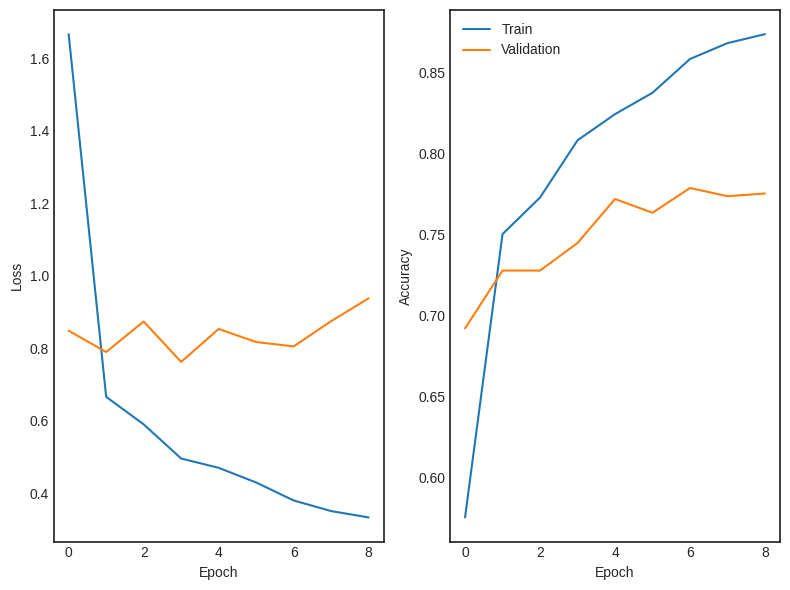

In [69]:
try: results
except NameError: results = None
if grading or not results:
    # Load the results
    with open(os.path.join(model_dir, 'flowers_vgg_results.pkl'), 'rb') as file:
        metrics = pickle.load(file)
elif not grading and results:  
    # Or get them from model training
    metrics = results.history

# Show best loss and accuracy
print(f"Train loss: {min(metrics['loss']):.3f}")
print(f"Train accuracy: {max(metrics['accuracy']):.3f}")
print(f"Best validation loss: {min(metrics['val_loss']):.3f}")
print(f"Best validation accuracy: {max(metrics['val_accuracy']):.3f}")

# Plot the training loss and accuracy
fig, ax = plt.subplots(1, 2, figsize=(8, 6), sharex=True, sharey=False)
ax[0].plot(metrics['loss'], label='Train Loss')
ax[0].plot(metrics['val_loss'], label='Validation Loss')
ax[0].set(xlabel='Epoch', ylabel='Loss')
ax[1].plot(metrics['accuracy'], label='Train Accuracy')
ax[1].plot(metrics['val_accuracy'], label='Validation Accuracy')
ax[1].set(xlabel='Epoch', ylabel='Accuracy')
plt.legend(['Train', 'Validation'])
plt.tight_layout()
plt.show()

/opt/conda/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


23/23 ━━━━━━━━━━━━━━━━━━━━ 129s 6s/step
Test Accuracy: 0.653


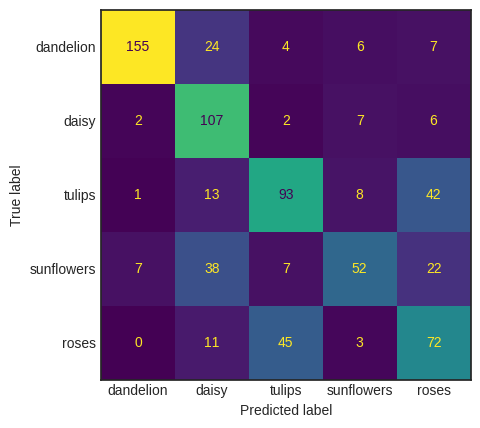

In [70]:
if not grading:
    # Load the best model
    model.load_weights(os.path.join(model_dir, 'flowers_vgg.weights.h5'))

    # Predict class labels for test set
    predictions = model.predict(X_test)
    predictions = np.argmax(predictions, axis=1)
    print(f'Test Accuracy: {accuracy_score(y_test, predictions):.3f}')

    # Print confusion matrix
    conf_matrix = ConfusionMatrixDisplay.from_predictions(y_test, predictions, display_labels=class_names, colorbar=False)
    plt.show()

<div class="alert alert-success" style="color:black"><h3>Before you submit this notebook to NBGrader for marking:</h3> 

1. Make sure have completed all exercises marked by <span style="color:blue">**blue cells**</span>.
2. For automatically marked exercises ensure you have completed any cells with `# YOUR CODE HERE`. Then click 'Validate' button above, or ensure all cells run without producing an error.
3. For manually marked exercises ensure you have completed any cells with `"YOUR ANSWER HERE"`.
4. Ensure all cells are run with their output visible.
5. Fill in your student ID (**only**) below.
6. You should now **save and download** your work.

</div>

**Student ID:** 15006280